# Développez un outil de prévision de la consommation d'énergie

Context: Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.
This archive contains 2075259 measurements gathered between December 2006 and November 2010 (47 months).

Notes:
1.(globalactivepower*1000/60 - submetering1 - submetering2 - submetering3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.
2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

Attribute Information:

1.date: Date in format dd/mm/yyyy<br>
2.time: time in format hh:mm:ss<br>
3.globalactivepower: household global minute-averaged active power (in kilowatt)<br>
4.globalreactivepower: household global minute-averaged reactive power (in kilowatt)<br>
5.voltage: minute-averaged voltage (in volt)<br>
6.global_intensity: household global minute-averaged current intensity (in ampere)<br>
7.submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).<br>
8.submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.<br>
9.submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from datetime import datetime
import seaborn as sns

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import SimpleRNN

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import math

# Preprocessing

In [10]:
data.shape

(2075259, 7)

In [11]:
# drop NaN in data
data.dropna(inplace=True)

In [12]:
data.shape

(2049280, 7)

In [13]:
# resample data by day
data_d=data.resample('D').sum()

In [14]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Freq: D
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    1442 non-null   float64
 1   Global_reactive_power  1442 non-null   float64
 2   Voltage                1442 non-null   float64
 3   Global_intensity       1442 non-null   float64
 4   Sub_metering_1         1442 non-null   float64
 5   Sub_metering_2         1442 non-null   float64
 6   Sub_metering_3         1442 non-null   float64
dtypes: float64(7)
memory usage: 90.1 KB


In [15]:
data_d.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,1442.0,1551.334856,617.297117,0.0,1161.1985,1534.778,1889.8595,4773.386
Global_reactive_power,1442.0,175.815258,51.998109,0.0,140.9115,170.290,202.3725,417.834
Voltage,1442.0,342266.507732,36707.752471,0.0,345621.8425,346934.710,348251.5275,356306.410
Global_intensity,1442.0,6576.681415,2559.505974,0.0,4988.8000,6510.300,7953.3500,20200.400
Sub_metering_1,1442.0,1594.407074,1587.840580,0.0,555.5000,1109.000,2196.7500,11178.000
Sub_metering_2,1442.0,1845.375173,2089.590342,0.0,424.2500,678.500,2712.7500,12109.000
Sub_metering_3,1442.0,9178.340499,3787.898093,0.0,6604.2500,9251.000,11708.5000,23743.000


In [9]:
# convert all columns object to float
#for i in data.select_dtypes(object):
#    data[i] = pd.to_numeric(data[i],errors = 'coerce')

In [16]:
data_d.shape

(1442, 7)

In [17]:
# define X / Y
# "data" and "targets" arguments are the same which means inputs and outputs all came from the same time-series
dataset_x = data_d.copy()
dataset_y = data_d['Global_active_power']

print(dataset_x.shape, dataset_y.shape)

(1442, 7) (1442,)


In [18]:
# split data : train / validation / test
train_samples = int(0.5 * len(data_d))
val_samples = int(0.25 * len(data_d))
test_samples = len(data_d) - train_samples - val_samples

print("Train size:", train_samples)
print("Validation size:", val_samples)
print("Test size:", test_samples)

Train size: 721
Validation size: 360
Test size: 361


In [19]:
# normalize data
data_ok = data_d.copy()

mean = data_ok[:train_samples].mean(axis=0)
data_ok -= mean
std = data_ok[:train_samples].std(axis=0)
data_ok /= std

data_ok.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16,-0.547070,-2.898016,-11.383077,-0.548840,-1.031362,-0.699703,-0.984828
2006-12-17,2.642748,1.209889,0.086665,2.689897,0.214094,0.920997,1.351801
2006-12-18,0.907464,-0.170577,0.161636,0.879917,-0.380147,0.223931,1.539786
2006-12-19,0.121254,-0.403829,0.211912,0.123376,-0.517374,2.441099,-0.631904
2006-12-20,0.939522,-0.187646,0.232134,0.903036,-1.031362,0.235950,1.552281


# Time series generator / LSTM

**Time Series Generator**

In [20]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
# time series generator parameters
sampling_rate = 1
look_back = 7
stride = 1
batch_size = 50
shuffle = False 

In [22]:
train_generator=TimeseriesGenerator(data_ok,
                                    data_ok['Global_active_power'],
                                    length=look_back,
                                    sampling_rate=sampling_rate,
                                    stride=stride,
                                    batch_size=batch_size,
                                    shuffle = shuffle)

val_generator=TimeseriesGenerator(data_ok,
                                   data_ok['Global_active_power'],
                                   length=look_back,
                                   sampling_rate=sampling_rate,
                                   stride=stride,
                                   batch_size=batch_size,
                                   shuffle = shuffle)

test_generator=TimeseriesGenerator(data_ok,
                                   data_ok['Global_active_power'],
                                   length=look_back,
                                   sampling_rate=sampling_rate,
                                   stride=stride,
                                   batch_size=batch_size,
                                   shuffle = shuffle)

In [23]:
# check if the time series generator makes 3D shape
X_train, y_train  = train_generator[0]

print(X_train.shape, y_train.shape)

(50, 7, 7) (50,)


In [24]:
X_test, y_test  = test_generator[0]

print(X_test.shape, y_test.shape)

(50, 7, 7) (50,)


In [25]:
look_back

7

In [26]:
num_features = X_train.shape[-1]
num_features

7

**Model LSTM**

In [27]:
model = Sequential()

model.add(LSTM(64,input_shape=(look_back, num_features),activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18432     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 18,497
Trainable params: 18,497
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model.fit(train_generator,epochs=10, validation_data=val_generator)

Epoch 1/10
29/29 [==============================] - 2s 23ms/step - loss: 0.5087 - val_loss: 0.4612
Epoch 2/10
29/29 [==============================] - 0s 12ms/step - loss: 0.4492 - val_loss: 0.4351
Epoch 3/10
29/29 [==============================] - 0s 13ms/step - loss: 0.4366 - val_loss: 0.4202
Epoch 4/10
29/29 [==============================] - 0s 14ms/step - loss: 0.4245 - val_loss: 0.4128
Epoch 5/10
29/29 [==============================] - 0s 12ms/step - loss: 0.4279 - val_loss: 0.4064
Epoch 6/10
29/29 [==============================] - 0s 13ms/step - loss: 0.4128 - val_loss: 0.4003
Epoch 7/10
29/29 [==============================] - 0s 13ms/step - loss: 0.4128 - val_loss: 0.3954
Epoch 8/10
29/29 [==============================] - 0s 13ms/step - loss: 0.4027 - val_loss: 0.3908
Epoch 9/10
29/29 [==============================] - 0s 13ms/step - loss: 0.4015 - val_loss: 0.3852
Epoch 10/10
29/29 [==============================] - 0s 14ms/step - loss: 0.3952 - val_loss: 0.3801


In [31]:
#model.save('model')

In [32]:
#from keras.models import load_model
#mymodel = load_model('model.h')

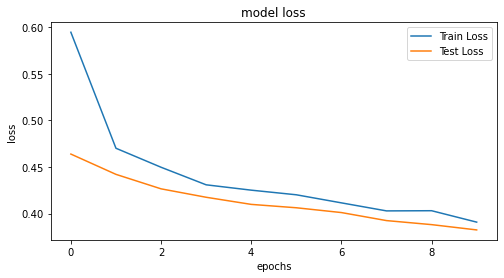

In [81]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [82]:
model.evaluate_generator(test_generator)

0.38242068886756897